In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, RobustScaler, MinMaxScaler, LabelEncoder
import klib
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

label_encoder = LabelEncoder()

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [107]:
asdf = pd.read_csv('/Users/jameslee/Downloads/Loan_Default.csv')

In [108]:
asdf.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [109]:
asdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

# EDA (hongik1.streamlit.app)

In [114]:
asdf['year'].unique() # 년도값이 다 2019로 삭제

array([2019])

In [116]:
asdf = asdf.drop(columns=['ID','year'])
asdf = klib.data_cleaning(asdf)

Shape of cleaned data: (148670, 32) - Remaining NAs: 181135


Dropped rows: 0
     of which 0 duplicates. (Rows (first 150 shown): [])

Dropped columns: 0
     of which 0 single valued.     Columns: []
Dropped missing values: 0
Reduced memory by at least: 27.22 MB (-74.99%)



In [117]:
asdf.groupby('status')['interest_rate_spread'].count() # 파산으로 분류하는 데이터에서 가산금리값이 없다

status
0    112031
1         0
Name: interest_rate_spread, dtype: int64

In [118]:
asdf.groupby('status')['upfront_charges'].count() # 가산금리 만큼은 아니지만 파산그룹의 데이터가 상당히 적다

status
0    108875
1       153
Name: upfront_charges, dtype: int64

### 결측치

In [120]:
asdf = asdf.drop(columns=['interest_rate_spread']) # 가산금리 삭제

numerical_columns = asdf.select_dtypes(exclude=['int8','category']).columns
categorical_columns = asdf.select_dtypes(include=['category', 'int8']).columns

# 수치형 변수는 status그룹별 평균, 범주형은 최빈치 사용
for column in numerical_columns:
    asdf[column] = asdf.groupby('status')[column].transform(lambda x: x.fillna(x.mean()))
for column in categorical_columns:
    asdf[column] = asdf.groupby('status')[column].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else x))

numerical_columns = numerical_columns.difference(['term'])

### 이상치

In [125]:
# 이상치 삭제
def clip_outliers(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)  
        Q3 = df[col].quantile(0.75)  
        IQR = Q3 - Q1               
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

clip_outliers(asdf, numerical_columns)

### 피쳐선택

In [19]:
from sklearn.feature_selection import mutual_info_classif

target = asdf['status']

features = asdf.drop(columns=['status'])

# 상호의존정보값을 통해 피쳐선택을 한다
encoded_features = features.copy()
for column in encoded_features.select_dtypes(include='category').columns:
    encoded_features[column] = LabelEncoder().fit_transform(encoded_features[column].astype(str))

mi_scores = mutual_info_classif(encoded_features, target, discrete_features='auto')

mi_scores_df = pd.DataFrame({'Feature': encoded_features.columns, 'Mutual Information Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)
mi_scores_df.head(7)

,Feature,Mutual Information Score
9,rate_of_interest,0.553025
10,upfront_charges,0.552428
29,dtir1,0.205586
26,ltv,0.181315
15,property_value,0.169869
21,credit_type,0.168911
20,income,0.047885


In [22]:
asdf['credit_type'].unique() # credit_type의 범주형 값을 파악하기 어려워 삭제

['EXP', 'EQUI', 'CRIF', 'CIB']
Categories (4, object): ['CIB', 'CRIF', 'EQUI', 'EXP']

### 점이연 상관계수

In [27]:
from scipy.stats import pointbiserialr

correlation, p_value = pointbiserialr(asdf['upfront_charges'], asdf['status'])
correlation

-0.26857067883589497

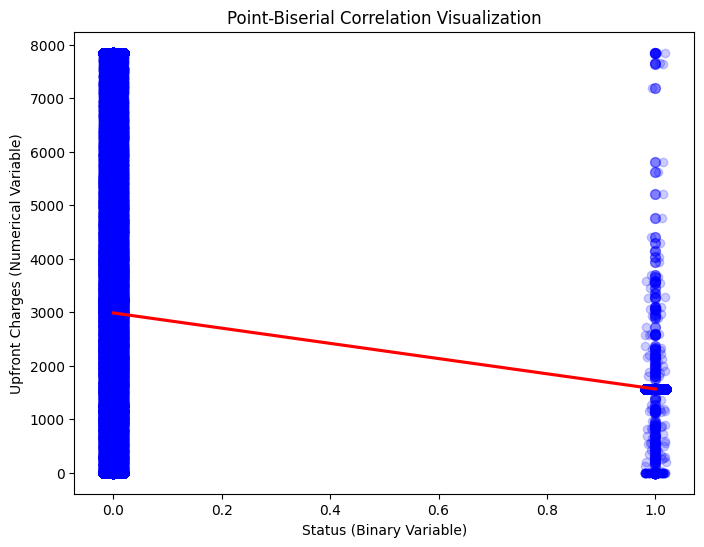

In [28]:
plt.figure(figsize=(8, 6))
sns.regplot(
    x='status',
    y='upfront_charges',
    data=asdf,
    logistic=False,
    scatter_kws={'alpha': 0.5, 's': 50, 'color': 'blue'},
    line_kws={'color': 'red'}
)

jittered_status = asdf['status'] + np.random.uniform(-0.02, 0.02, size=len(asdf['status']))
plt.scatter(jittered_status, asdf['upfront_charges'], alpha=0.2, color='blue')

plt.title('Point-Biserial Correlation Visualization')
plt.xlabel('Status (Binary Variable)')
plt.ylabel('Upfront Charges (Numerical Variable)')
plt.show()


상관계수가 -0.2686이라 upfront_charges와 이진 변수 status 간에 약한 음의 상관관계가 있을 뿐만 아니라 파산그룹의 데이터가 상당히 적기 때문에 피쳐선택에서 삭제

In [32]:
asdf[['property_value','ltv', 'income','dtir1','rate_of_interest']].corr()

,property_value,ltv,income,dtir1,rate_of_interest
property_value,1.000000,-0.421001,0.524982,-0.056764,-0.161105
ltv,-0.421001,1.000000,-0.040084,0.154659,0.049485
income,0.524982,-0.040084,1.000000,-0.299980,-0.103758
dtir1,-0.056764,0.154659,-0.299980,1.000000,0.074601
rate_of_interest,-0.161105,0.049485,-0.103758,0.074601,1.000000


In [33]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

vif = asdf[['property_value', 'ltv', 'income', 'dtir1', 'rate_of_interest']]


# 분산팽창용인 계산
vif_data = pd.DataFrame()
vif_data["Feature"] = vif.columns
vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(vif.shape[1])]

print(vif_data)

            Feature        VIF
0    property_value   8.048173
1               ltv  21.382108
2            income   7.407452
3             dtir1  20.247327
4  rate_of_interest  29.224417


In [83]:
vif_data

,Feature,VIF
0,property_value,8.048173
1,ltv,21.382108
2,income,7.407452
3,dtir1,20.247327
4,rate_of_interest,29.224417


ltv, dtir1, rate_of_interest 값이 10이 넘어 pca 사용

In [35]:
risk = asdf.copy()

for col in ['property_value','ltv', 'income','dtir1','rate_of_interest']:
    # 0일 경우 1로 바꿈
    risk[col] = risk[col].apply(lambda x: np.log(x + 1) if x >= 0 else 1)

label_encoder = LabelEncoder()
risk['age'] = label_encoder.fit_transform(risk['age'])

X = risk[['property_value','ltv', 'income','dtir1','rate_of_interest']]
y = risk['status']

# 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 주성분분석
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])

# 각 주성분의 분산
explained_variance_ratio = pca.explained_variance_ratio_

# 4개의 주성분 선택
pca_4 = PCA(n_components=4)
X_pca_4 = pca_4.fit_transform(X_scaled)

pca_4_df = pd.DataFrame(X_pca_4, columns=[f'PC{i+1}' for i in range(4)])
pca_4_df['age'] = risk['age'].values
X_train, X_test, y_train, y_test = train_test_split(pca_4_df, y, test_size=0.5, random_state=42)

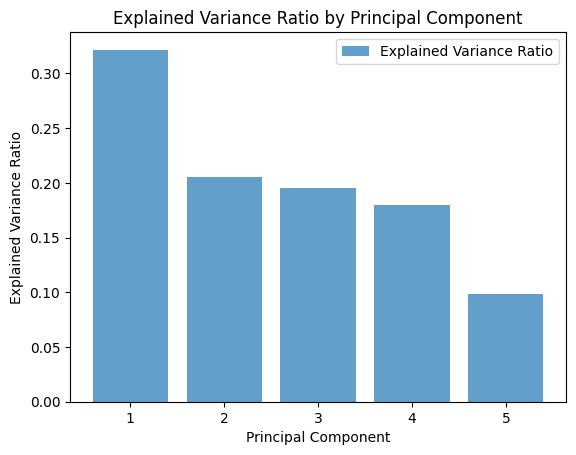

In [36]:
num_components = np.arange(1, len(explained_variance_ratio) + 1)

# 주성분 시각화
plt.bar(num_components, explained_variance_ratio, alpha=0.7, align='center', label='Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.xticks(num_components)
plt.legend()
plt.show()

# Model Implementation

## Decision Tree

              precision    recall  f1-score   support

           0       0.94      0.95      0.94     56145
           1       0.83      0.82      0.83     18190

    accuracy                           0.92     74335
   macro avg       0.89      0.88      0.89     74335
weighted avg       0.92      0.92      0.92     74335



/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


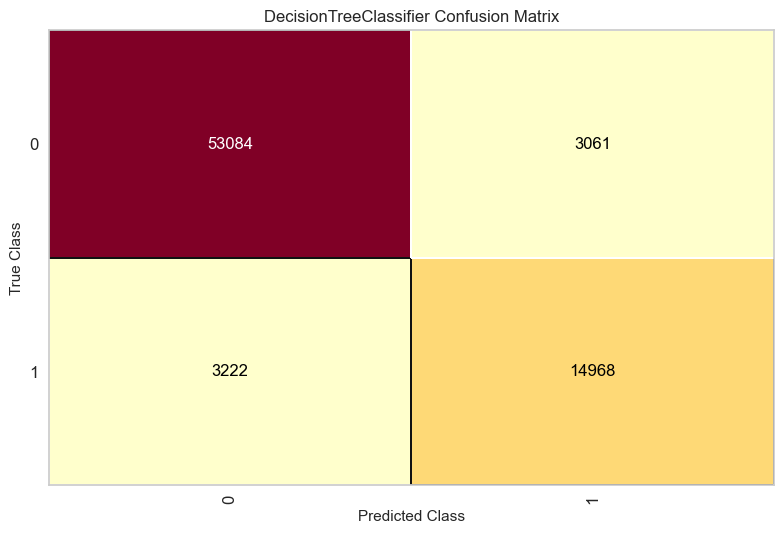

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


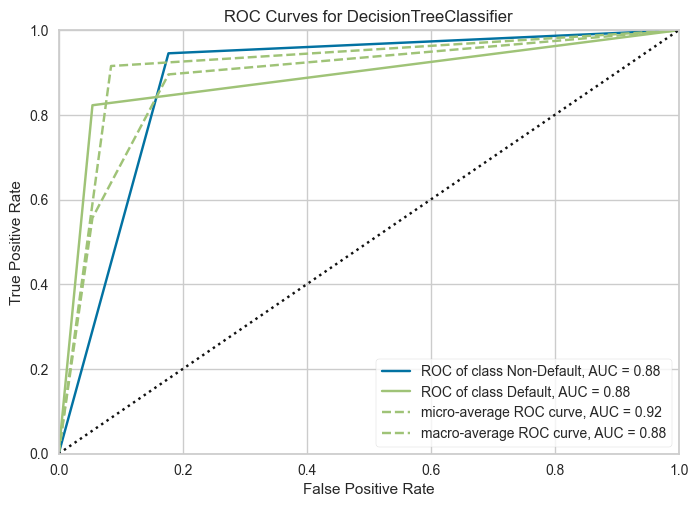

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
from yellowbrick.classifier import ConfusionMatrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from yellowbrick.classifier import ROCAUC

# 결정트리
dt_model = DecisionTreeClassifier(random_state=42,class_weight='balanced')
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

print(classification_report(y_test, y_pred))

# confusion matrix
visualizer = ConfusionMatrix(dt_model, classes=dt_model.classes_)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


# roc auc curve
visualizer = ROCAUC(dt_model, classes=["Non-Default", "Default"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Decision Tree with GridSearch

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters: {'criterion': 'entropy', 'min_samples_leaf': 3, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     56145
           1       0.82      0.83      0.83     18190

    accuracy                           0.91     74335
   macro avg       0.88      0.89      0.88     74335
weighted avg       0.91      0.91      0.91     74335



/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


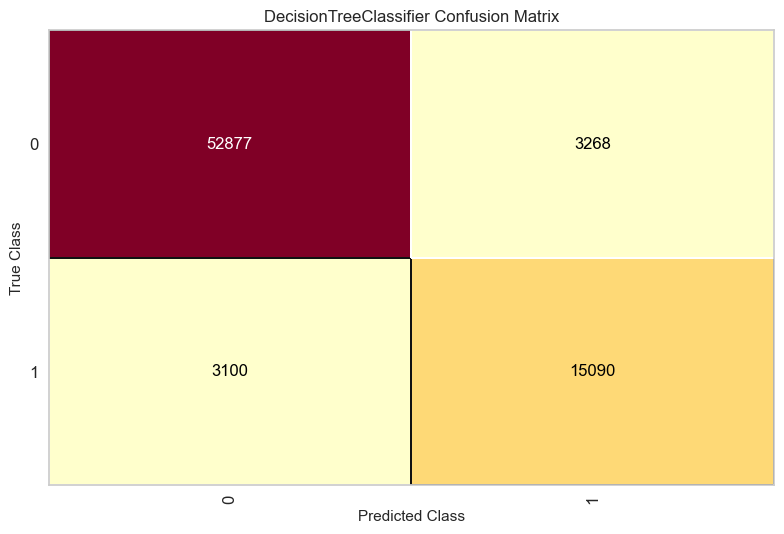

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


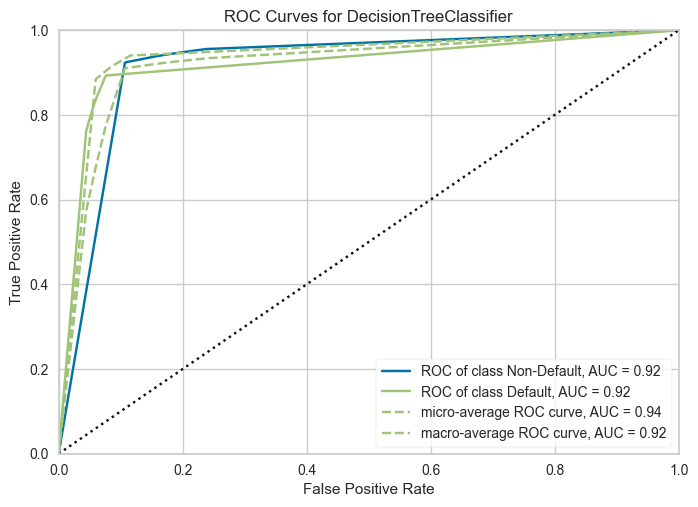

<Axes: title={'center': 'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [41]:
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ConfusionMatrix

# 하이퍼파라미터 튜닝을 위해 gridsearch이용
param_grid = {
    'criterion': ['gini', 'entropy'],                   
    'min_samples_split': [2, 5, 7, 10],                
    'min_samples_leaf': [2, 3, 5, 10],                  
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy', 
    cv=5,                  
    verbose=1,             
    n_jobs=-1              
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

# 좋은 하이퍼파라미터 출력
print("Best Parameters:", grid_search.best_params_)

y_pred_best = best_model.predict(X_test)

print(classification_report(y_test, y_pred_best))

visualizer = ConfusionMatrix(best_model, classes=best_model.classes_)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

visualizer = ROCAUC(best_model, classes=["Non-Default", "Default"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## Deep Neural Network

In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam


# 5개의 층과 relu 활성화 함수 사용
model = Sequential([
    # 64 뉴런 input layer
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    # 32 뉴런 hidden layer
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),

    # 0과 1 사이의 값을 변환 
    Dense(1, activation='sigmoid') 
])

# Adam 옵티마이저, 0.001의 학습률
model.compile(optimizer=Adam(learning_rate=0.001),
              # 이진 분류 손실 함수
              loss='binary_crossentropy',
              # 정확도로 평가
              metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test),
                    # 전체 데이터셋을 5번 반복하여 학습
                    epochs=5, 
                    # 한 번의 업데이트에 사용할 샘플의 수를 32
                    batch_size=32, 
                    verbose=1)

Epoch 1/5


/Users/jameslee/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2323/2323 ━━━━━━━━━━━━━━━━━━━━ 3s 912us/step - accuracy: 0.9050 - loss: 0.2283 - val_accuracy: 0.9506 - val_loss: 0.1232
Epoch 2/5
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 2s 808us/step - accuracy: 0.9514 - loss: 0.1230 - val_accuracy: 0.9546 - val_loss: 0.1092
Epoch 3/5
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 2s 871us/step - accuracy: 0.9539 - loss: 0.1130 - val_accuracy: 0.9566 - val_loss: 0.1012
Epoch 4/5
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 2s 936us/step - accuracy: 0.9550 - loss: 0.1050 - val_accuracy: 0.9559 - val_loss: 0.1034
Epoch 5/5
2323/2323 ━━━━━━━━━━━━━━━━━━━━ 2s 881us/step - accuracy: 0.9569 - loss: 0.0988 - val_accuracy: 0.9567 - val_loss: 0.0988


In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,829 (54.02 KB)

 Trainable params: 4,609 (18.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,220 (36.02 KB)

In [45]:
# threshold를 달리해 class 1 (파산)의 f1-score, 특히 재현율이 높은 값을 선택
for i in [0.1,0.3,0.5]:
    y_pred = (model.predict(X_test) >= i).astype(int)
    print(f"Threshold: {i}")
    print(classification_report(y_test, y_pred))

# threshold가 0.3일때 파산한 그룹의 f1-score을 비롯한 재현율이 가장 높다

2323/2323 ━━━━━━━━━━━━━━━━━━━━ 1s 333us/step
Threshold: 0.1
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     56145
           1       0.82      0.99      0.90     18190

    accuracy                           0.95     74335
   macro avg       0.91      0.96      0.93     74335
weighted avg       0.95      0.95      0.95     74335

2323/2323 ━━━━━━━━━━━━━━━━━━━━ 1s 320us/step
Threshold: 0.3
              precision    recall  f1-score   support

           0       0.99      0.95      0.97     56145
           1       0.86      0.97      0.91     18190

    accuracy                           0.95     74335
   macro avg       0.92      0.96      0.94     74335
weighted avg       0.96      0.95      0.95     74335

2323/2323 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step
Threshold: 0.5
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     56145
           1       0.91      0.92      0.91     18190

  

2323/2323 ━━━━━━━━━━━━━━━━━━━━ 1s 343us/step


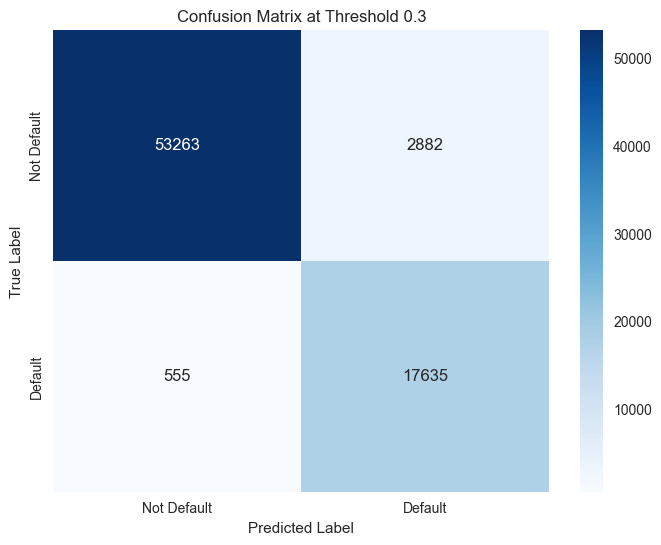

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

threshold = 0.3
y_pred = (model.predict(X_test) >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Default", "Default"], yticklabels=["Not Default", "Default"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix at Threshold {threshold}')
plt.show()

2323/2323 ━━━━━━━━━━━━━━━━━━━━ 1s 345us/step


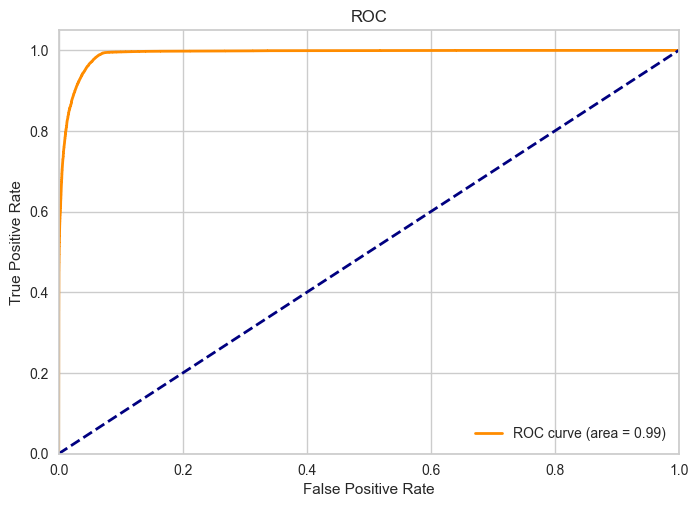

In [79]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

y_prob = model.predict(X_test)

# 파산한 그룹이 양성일떄 확률계산
if y_prob.shape[1] == 2:
    y_prob = y_prob[:, 1]

# ROC, AUC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# 그래프 시각화
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc='lower right')
plt.show()

## KNN 

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     56145
           1       0.87      0.74      0.80     18190

    accuracy                           0.91     74335
   macro avg       0.89      0.85      0.87     74335
weighted avg       0.91      0.91      0.91     74335



/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


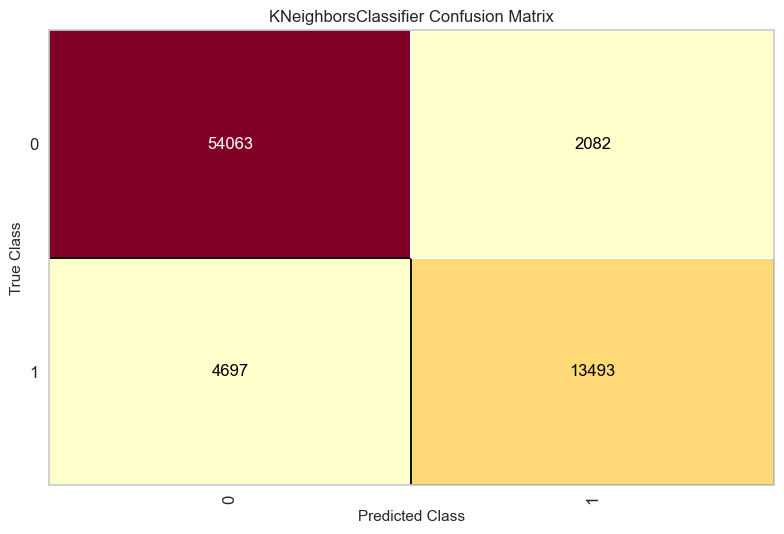

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


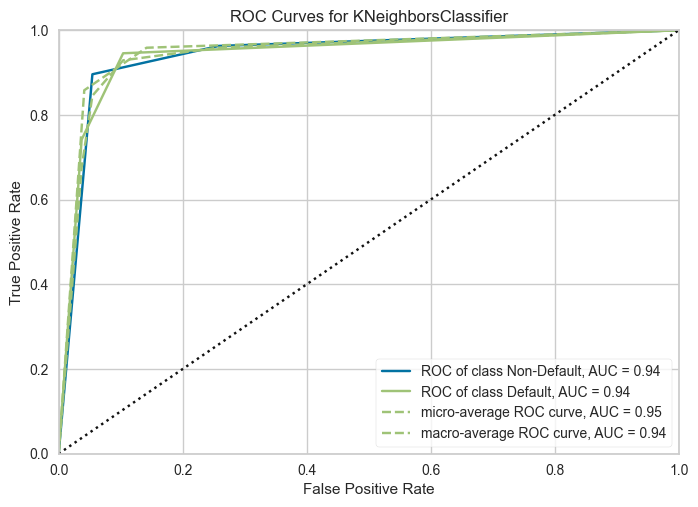

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
from sklearn.neighbors import KNeighborsClassifier

# KNN 모델
knn = KNeighborsClassifier(n_neighbors=2)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))

visualizer = ConfusionMatrix(knn, classes=knn.classes_)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

visualizer = ROCAUC(knn, classes=["Non-Default", "Default"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## KNN GridSearch

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Hyperparameters: {'metric': 'euclidean', 'n_neighbors': 4, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.96      0.93      0.94     56145
           1       0.81      0.87      0.84     18190

    accuracy                           0.92     74335
   macro avg       0.88      0.90      0.89     74335
weighted avg       0.92      0.92      0.92     74335



/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


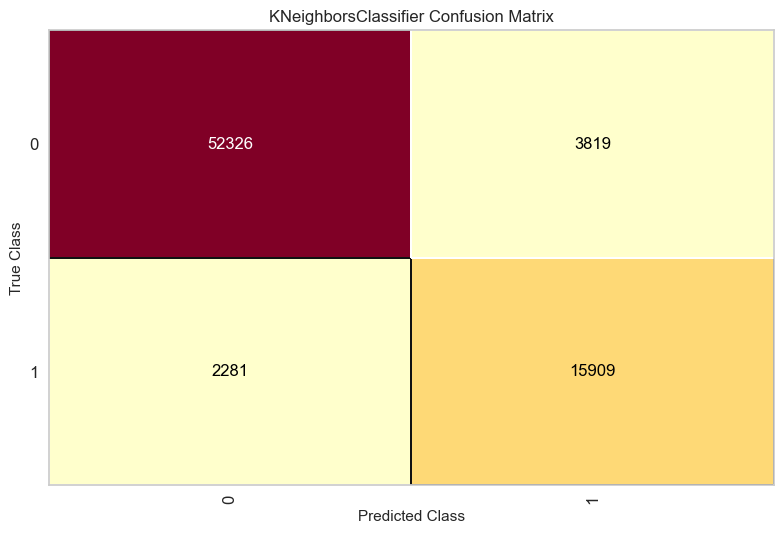

/Users/jameslee/anaconda3/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


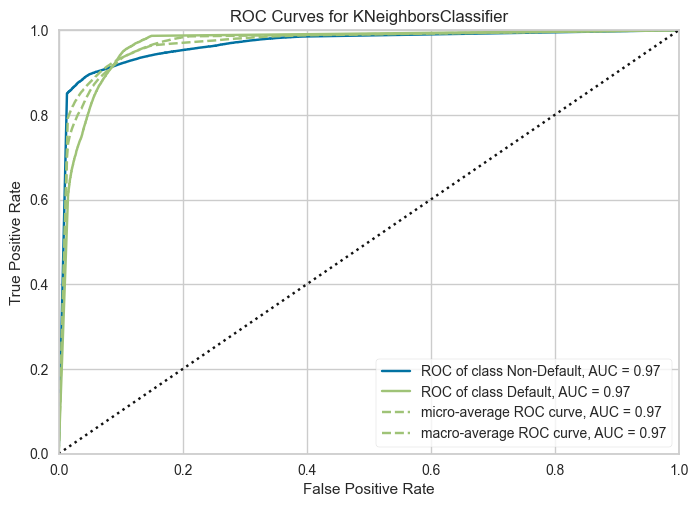

<Axes: title={'center': 'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
# 하이퍼파라미터 튜닝
param_grid = {
    'n_neighbors': np.arange(1, 5),  
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model2 = grid_search.best_estimator_
print(f"Best Hyperparameters: {grid_search.best_params_}")

y_pred = best_model2.predict(X_test)

print(classification_report(y_test, y_pred))

visualizer = ConfusionMatrix(best_model2, classes=best_model.classes_)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

visualizer = ROCAUC(best_model2, classes=["Non-Default", "Default"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

파산한 그룹의 f1-score가 가장 높은 모델은 인공신경망이다.

# Clustering

In [168]:
# 파산한 그룹을 클러스터링 
df = asdf[asdf['status'] == 1]
df = df[['property_value','ltv', 'income','dtir1','age']]
scaler = StandardScaler()
df[['property_value','ltv', 'income','dtir1']] = scaler.fit_transform(df[['property_value','ltv', 'income','dtir1']])
df = pd.get_dummies(df, columns=['age'], drop_first=False)

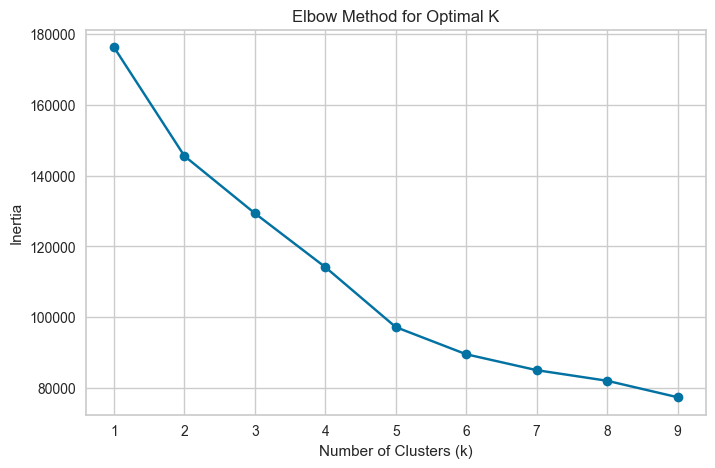

In [172]:
from sklearn.cluster import KMeans

X = df
inertia = []

k_values = range(1, 10) 

inertia = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [187]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

cluster_means = df.groupby('Cluster').mean()

In [189]:
cluster_means

,property_value,ltv,income,dtir1,age_25-34,age_35-44,age_45-54,age_55-64,age_65-74,age_<25,age_>74
Cluster,,,,,,,,,,,
0,2.275678,-1.552028,0.715928,-0.056319,0.050711,0.153989,0.268398,0.275201,0.176252,0.001546,0.073902
1,-0.898774,1.064243,-0.388811,0.762876,0.158456,0.198509,0.207572,0.223652,0.136676,0.022804,0.052332
2,-0.683461,-0.023378,-0.376413,-1.807539,0.111925,0.192269,0.226630,0.256443,0.151844,0.012885,0.048004
3,-0.019807,-0.227816,-0.511415,0.169770,0.110550,0.168545,0.200262,0.244758,0.188663,0.009502,0.077720
4,0.244535,0.178026,1.312085,-0.064409,0.118432,0.288592,0.286959,0.197659,0.079771,0.004084,0.024503
